# The netCDF file format

* popular scientific file format for ocean and atmospere gridded datasets
* netCDF is a collection of formats for storing arrays

    * netCDF classic
        * more widespread
        * 2 GB file limit
        * often preffered for distributing products

    * netCDF 64 bit offset
        * supports larger files

    * NetCDF4
        * based on HDF5
        * compression
        * multiple unlimited variables
        * new types inc. user defined
        * herarchical groups
        
        

* Developed by Unidata-UCAR with the aim of storing climate model data (3D+time)
* Auxilary information about each variable can be added
* Readable text equivalent called CDL (use ncdump/ncgen)
* Can be used with Climate and Forecast (CF) data convention
http://cfconventions.org/

## Data model:

* Dimensions:describe the axes of the data arrays.
* Variables: N-dimensional arrays of data.
* Attributes: annotate variables or files with small notes or supplementary metadata.

Example for an ocean model dataset:

* Dimensions
    * lat
    * lon
    * depth
    * time
* Variable
    * Temperature
    * Salinity
* Global Attibutes
    * Geographic grid type
    * History



* Variable attributes (Temperature)
    * Long_name: "sea water temperature" 
    * Missing_value: 1.09009E36
    * Units: deg. C
    * range: -2:50

## Tools for working with netCDF files

### C and Fortran libraries
Used to underpin interfaces to other languages such as python (e.g. python package netCDF4)

Include ncdump/ncgen to convert to and from human readable format.

### nco tools http://nco.sourceforge.net/nco.html
Command line utilities to extract, create and operate data in netCDF files.

```
    > ncks -v u_wind -d lat,50.,51. -d lon,0.,5 inputfile.nc outputfile.nc
```

### cdo tools
Another powerful CLI utility https://code.mpimet.mpg.de/projects/cdo/

### Viewers
ncdump, ncview, panoply, etc.

### Readable by many software tools
ArcGIS, QGIS, Surfer, Ferret, Paraview etc.

### Python packages
* The main Python interface to the netCDF C library is [netCDF4](http://unidata.github.io/netcdf4-python/) package
* In this tutorial, however, we will use a more high-level package that has a **pandas-like API**: [xarray](http://xarray.pydata.org/en/stable/index.html).
* Another good package is [iris](http://scitools.org.uk/iris/).

# Working with netCDF files using xarray

* Alternative to plain netCDF4 access from python. 

* Brings the power of pandas to environmental sciences, by providing N-dimensional variants of the core pandas data structures:

* worth using for multidimensional data even when not using 

| Pandas | xarray  |
|---|---|
| Series  | DataArray  |
| DataFrame  | Dataset  |


DataArray uses names of dimensions making it easier to track than by using axis numbers. It is possible to write:

`da.sel(time='2000-01-01')` or `da.mean(dim='time')`
intead of ``df.mean(0)``

HTML documentation: http://xarray.pydata.org/

Thus, xarray operations allow you to use names, not numbers!
Compare:
```python
# xarray style
>>> ds.sel(time='2018-01-12').max(dim='ensemble')

# numpy style
>>> array[[0, 1, 2, 3], :, :].max(axis=2)
```

(Taken from Stephan Hoyer's [ECMWF talk](https://docs.google.com/presentation/d/16CMY3g_OYr6fQplUZIDqVtG-SKZqsG8Ckwoj2oOqepU/edit#slide=id.g2b68f9254d_1_27))

## Example dataset
http://xarray.pydata.org/en/stable/data-structures.html

<br>
<img src="../figures/dataset-diagram.png">


Xarray as Pandas for N dimensions

In [32]:
# Import everything that we are going to need... but not more
import pandas as pd
import xarray as xr
import numpy as np

In [45]:
pd_s = pd.Series(range(3), index=list('abc'))
pd_s

a    0
b    1
c    2
dtype: int64

In [44]:
#convert 1D series to ND aware DataArray 
print(xr.DataArray(pd_s))

<xarray.DataArray (dim_0: 3)>
array([0, 1, 2], dtype=int64)
Coordinates:
  * dim_0    (dim_0) object 'a' 'b' 'c'


In [46]:
#convert DataFrame to ND aware DataArray
df = pd.DataFrame.from_items([('A', [1, 2, 3]), ('B', [4, 5, 6])],                         
                             orient='index', columns=['one', 'two', 'three'])
df

,one,two,three
A,1,2,3
B,4,5,6


In [47]:
ds = xr.Dataset.from_dataframe(df)
ds

<xarray.Dataset>
Dimensions:  (index: 2)
Coordinates:
  * index    (index) object 'A' 'B'
Data variables:
    one      (index) int64 1 4
    two      (index) int64 2 5
    three    (index) int64 3 6

### The main advantages of using xarray versus plain netCDF4 are:

* intelligent selection along labelled dimensions (and also indexes)
* groupby operations
* data alignment
* IO (netcdf)
* conversion from and to Pandas.DataFrames

### Lets peek inside our example file using ncdump

```
$ ncdump data/cefas_GETM_nwes.nc | more
netcdf cefas_GETM_nwes {
dimensions:
        latc = 360 ;
        lonc = 396 ;
        time = UNLIMITED ; // (6 currently)
        level = 5 ;
variables:
        double bathymetry(latc, lonc) ;
                bathymetry:units = "m" ;
                bathymetry:long_name = "bathymetry" ;
                bathymetry:valid_range = -5., 4000. ;
                bathymetry:_FillValue = -10. ;
                bathymetry:missing_value = -10. ;
        float h(time, level, latc, lonc) ;
                h:units = "m" ;
                h:long_name = "layer thickness" ;
                h:_FillValue = -9999.f ;
                h:missing_value = -9999.f ;
        double latc(latc) ;
                latc:units = "degrees_north" ;
        double level(level) ;
                level:units = "level" ;
        double lonc(lonc) ;
                lonc:units = "degrees_east" ;
        float temp(time, level, latc, lonc) ;
                temp:units = "degC" ;
                temp:long_name = "temperature" ;
                temp:valid_range = -2.f, 40.f ;
                temp:_FillValue = -9999.f ;
                temp:missing_value = -9999.f ;
        double time(time) ;
                time:long_name = "time" ;
                time:units = "seconds since 1996-01-01 00:00:00" ;
```

Now let's go back to python and use xarray.

## Import remote dataset

xarray supports OpenDAP. This means that a dataset can be accessed remotely and subsetted as needed. Only the selected parts are downloaded.

In [50]:
# Naughty datasets might require decode_cf=False
# Here it just needed decode_times=False

naughty_data = xr.open_dataset(
      'http://iridl.ldeo.columbia.edu/SOURCES/.OSU/.PRISM/.monthly/dods',
      decode_times=False)
naughty_data

<xarray.Dataset>
Dimensions:  (T: 1420, X: 1405, Y: 621)
Coordinates:
  * X        (X) float32 -125.0 -124.958 -124.917 -124.875 -124.833 -124.792 ...
  * T        (T) float32 -779.5 -778.5 -777.5 -776.5 -775.5 -774.5 -773.5 ...
  * Y        (Y) float32 49.9167 49.875 49.8333 49.7917 49.75 49.7083 ...
Data variables:
    ppt      (T, Y, X) float64 ...
    tdmean   (T, Y, X) float64 ...
    tmax     (T, Y, X) float64 ...
    tmin     (T, Y, X) float64 ...
Attributes:
    expires:      1370044800
    Conventions:  IRIDL

### ...or import local dataset

In [51]:
GETM = xr.open_dataset('../data/cefas_GETM_nwes.nc4')
GETM

<xarray.Dataset>
Dimensions:     (latc: 360, level: 5, lonc: 396, time: 6)
Coordinates:
  * latc        (latc) float64 45.4 45.45 45.5 45.55 45.6 45.65 45.7 45.75 ...
  * level       (level) float64 1.0 6.0 11.0 16.0 21.0
  * lonc        (lonc) float64 -17.5 -17.42 -17.34 -17.26 -17.18 -17.1 ...
  * time        (time) datetime64[ns] 1996-02-01T01:00:00 ...
Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float64 ...
    temp        (time, level, latc, lonc) float64 ...
Attributes:
    title:                     North West European Shelf 3nm
    history:                   Sun Nov 20 00:54:48 2016: ncks -v time,latc,lo...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

In [7]:
GETM.dims

Frozen(SortedKeysDict({'latc': 360, 'lonc': 396, 'time': 6, 'level': 5}))

In [8]:
print(type(GETM.coords['latc']))
GETM.coords['latc'].shape

<class 'xarray.core.dataarray.DataArray'>


(360,)

In [53]:
# List name of dataset attributes
GETM.attrs.keys()

odict_keys(['title', 'history', 'NCO', 'nco_openmp_thread_number'])

In [54]:
# List variable names
GETM.data_vars.keys()

KeysView(Data variables:
    bathymetry  (latc, lonc) float64 ...
    h           (time, level, latc, lonc) float64 ...
    temp        (time, level, latc, lonc) float64 ...)

Extract variable from dataset

In [55]:
temp = GETM['temp']
print(type( temp ))
temp.shape

<class 'xarray.core.dataarray.DataArray'>


(6, 5, 360, 396)

Access variable attributes

In [58]:
# print variable attributes

for at, val in temp.attrs.items():
    print(f'{at:<15}: {val}')

units          : degC
long_name      : temperature
valid_range    : [ -2.  40.]


## Accessing data values

In [67]:
temp[0, 0, 90, 100]

<xarray.DataArray 'temp' ()>
array(11.532867431640625)
Coordinates:
    latc     float64 49.9
    level    float64 1.0
    lonc     float64 -9.5
    time     datetime64[ns] 1996-02-01T01:00:00
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [ -2.  40.]

In [68]:
#temp.values[0, 0, 90, 100]

## Indexing and selecting data

From http://xarray.pydata.org/
<br>
<img src="../figures/xarray_indexing_table.png">

In [71]:
#positional by integer
print( temp[0, 2, :, :].shape )

# positional by label
print( temp.loc['1996-02-02T01:00:00', :, :, :].shape )

# by name and integer
print( temp.isel(level=1, latc=90, lonc=100).shape )

# by name and label
print( temp.sel(time='1996-02-02T01:00:00').shape )
#temp.loc

(360, 396)
(5, 360, 396)
(6,)
(5, 360, 396)


### Define selection using nearest value

In [80]:
#GETM.sel(level=1)['temp']
GETM['temp'].sel(level=2, lonc=-5.0, latc=50.0, method='nearest')

<xarray.DataArray 'temp' (time: 6)>
array([ 9.513756,  9.479022,  9.506635,  9.484008,  9.596508,  9.748465])
Coordinates:
    latc     float64 50.0
    level    float64 1.0
    lonc     float64 -5.02
  * time     (time) datetime64[ns] 1996-02-01T01:00:00 1996-02-02T01:00:00 ...
Attributes:
    units:        degC
    long_name:    temperature
    valid_range:  [ -2.  40.]

In [82]:
# Use tolerance for label selection (lat=-50 should not yield data)
tol = 0.5

try:
    GETM['temp'].sel(level=1, lonc=-5.0, latc=-50.0, method='nearest', tolerance=tol)
except KeyError:
    print(f'ERROR: outside tolerance of {tol}')

ERROR: outside tolerance of 0.5


## Plotting

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

Define a general mapping function using cartopy

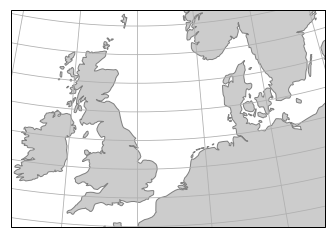

In [110]:
#def make_map(ds, var='', title=None, units=None):
def make_map():
    # create figure and axes instances
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=ccrs.Stereographic(central_latitude=60))
    #ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_extent([-10, 15, 49, 60], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(draw_labels=False)
    
    feature = cartopy.feature.NaturalEarthFeature(name='coastline',
                                                  category='physical',
                                                  scale='50m',
                                                  edgecolor='0.5',
                                                  facecolor='0.8')
    ax.add_feature(feature)
    return fig, ax

make_map();

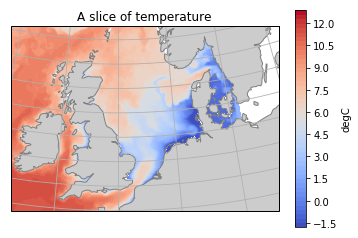

In [119]:
latc = GETM.coords['latc']
lonc = GETM.coords['lonc']

var = GETM.temp.sel(time='1996-02-02T01:00:00', level=21)

# create arrays of coordinates for contourf
# lon2d, lat2d = np.meshgrid(lonc, latc)

fig, ax = make_map()
# draw filled contours.
h = ax.contourf(lonc, latc, var, 50, cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# add colorbar.
cbar = fig.colorbar(h)
cbar.set_label(var.units)

# add title
ax.set_title(f'A slice of {var.long_name}');

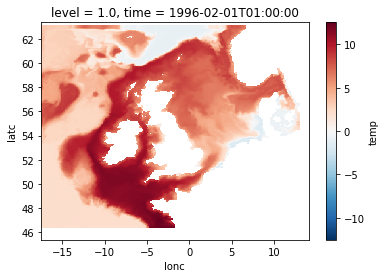

In [116]:
# But often, this will do
GETM.temp.isel(time=0, level=0).plot();

## Arithmetic operations

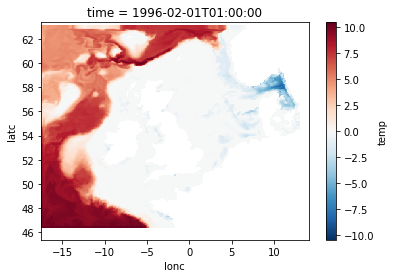

In [21]:
top = GETM['temp'].isel(time=0, level=4)
bottom = GETM['temp'].isel(time=0, level=0)

diff = top - bottom

diff.plot()

### Calculate average along a dimension

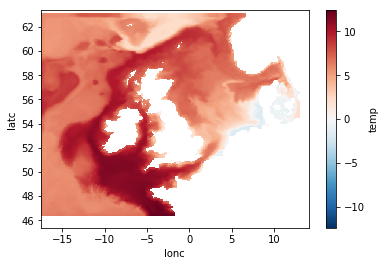

In [22]:
# average over time
time_ave = GETM['temp'].mean('time')

#average over time and level (vertical)
timelev_ave = GETM['temp'].mean(['time','level'])

timelev_ave.plot()

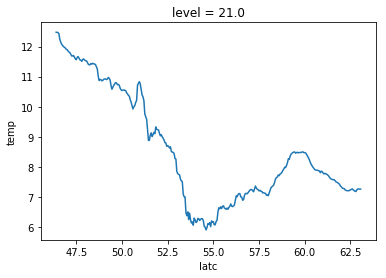

In [121]:
#zonal average (vertical)
timelon_ave = GETM['temp'].mean(['time','lonc']).isel(level=4)

timelon_ave.plot()

## A dataset can easily be saved to a netCDF file

In [24]:
ds = GETM[['temp']].mean('time','level')
ds.to_netcdf('../data/temp_avg_level_time.nc')

In [25]:
print(type( GETM[['temp']]) )
print(type( GETM['temp'])   )

<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataarray.DataArray'>


## Exercise

* Extract the bathymetry
* Extract the time averaged seabed temperature (level=0)
* Produce a scatter plot of depth vs. seabed temperature


In [26]:
# bathy = GETM

# bedtemp=GETM

# plt.scatter(  , ,marker='.')

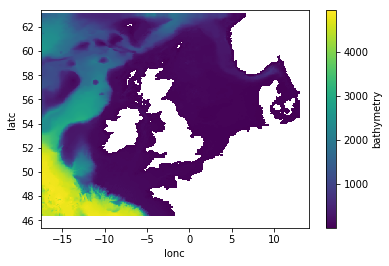

In [172]:
bathy = GETM['bathymetry']
bathy.plot();

<xarray.DataArray 'temp' (latc: 360, lonc: 396)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * latc     (latc) float64 45.4 45.45 45.5 45.55 45.6 45.65 45.7 45.75 45.8 ...
    level    float64 1.0
  * lonc     (lonc) float64 -17.5 -17.42 -17.34 -17.26 -17.18 -17.1 -17.02 ...

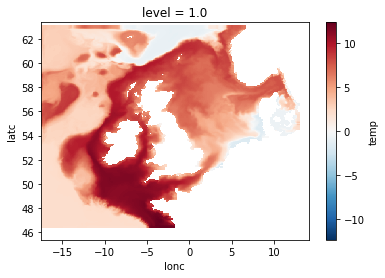

In [173]:
bedtemp=GETM['temp'].isel(level=0).mean('time')
bedtemp.plot()
bedtemp
#plt.scatter(bathy,bedtemp)

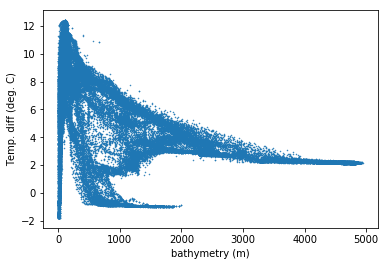

In [174]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(bathy,bedtemp,marker='.',s=1.0)
ax.set_xlabel('bathymetry (m)')
ax.set_ylabel('Temp. diff (deg. C)');